# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime

def imread(path):
    from PIL import Image
    return np.array(Image.open(path))

def imresize(img, size):
    from PIL import Image
    return np.array(Image.fromarray(img).resize(size))

from matplotlib.pyplot import imread
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow.keras import backend as K
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,tot_frames,ht,wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,tot_frames,ht,wd,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 32 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 32


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, GRU, Flatten, TimeDistributed, Dense, MaxPool3D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here

In [7]:
# Specifying constants
num_classes = 5  # total no of classes
ht = 84         # height of image (desired)
wd = 84         # width of image (desired)
tot_frames = len([0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29])


In [15]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [LR]

In [16]:
conv3d_model1 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
optimiser = "adam" #write your optimizer
conv3d_model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 9, 42, 42, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 9, 42, 42, 32)     13856     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 21, 21, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 4, 21, 21, 64)     55360     
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 2, 10, 10, 64)     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)            

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
history=conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - 217s 20s/step - loss: 1.8578 - categorical_accuracy: 0.1851 - val_loss: 1.5807 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2022-07-1115_01_11.870922/model-00001-1.74294-0.19306-1.58068-0.23000.h5
Epoch 2/15
11/11 [==============================] - 125s 12s/step - loss: 1.5686 - categorical_accuracy: 0.2305 - val_loss: 1.4964 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model_init_2022-07-1115_01_11.870922/model-00002-1.56481-0.21418-1.49638-0.29000.h5
Epoch 3/15
11/11 [==============================] - 109s 11s/step - loss: 1.4393 - categorical_accuracy: 0.3484 - val_loss: 1.3230 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to model_init_2022-07-1115_01_11.870922/model-00003-1.42571-0.35897-1.32303-0.36000.h5
Epoch 4/15
11/11 [==============================] - 118s 12s/step - loss: 1.3411 - categorical_accuracy: 0.4

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

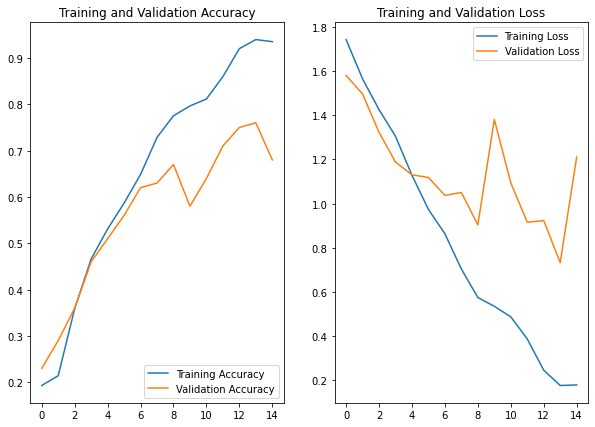

In [16]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
conv3d_model1.save('model-1.h5')

we have Created the model without BatchNormalization and Dropout and activation function ReLU and here we can see model is overfitting having good accuracy score with training and very poor accuracy score with validation

#### Now we will create a model with BatchNormalization and Dropout and also increasing the bathch size to 128

In [18]:
C3d_model2 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    BatchNormalization(),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [19]:
# Compiling
C3d_model2.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(C3d_model2.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 84, 84, 16)    64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 9, 42, 42, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 9, 42, 42, 32)     13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 42, 42, 32)     128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 21, 21, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 4, 21, 21, 64)    

In [20]:
#setting batch size 128
batch_size = 128

# For training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# For validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1

In [21]:
# Generators Object
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

In [ ]:
# Fitting the model
history = C3d_model2.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Source path =  Project_data/train ; batch size = 128
Epoch 1/15
6/6 [==============================] - 116s 23s/step - loss: 10.3746 - categorical_accuracy: 0.2104 - val_loss: 1.6080 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2022-07-1115_01_11.870922/model-00001-10.08488-0.22021-1.60801-0.18000.h5
Epoch 2/15
6/6 [==============================] - 147s 29s/step - loss: 2.2907 - categorical_accuracy: 0.2293 - val_loss: 1.6094 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2022-07-1115_01_11.870922/model-00002-2.04995-0.23982-1.60941-0.20000.h5
Epoch 3/15
6/6 [==============================] - 120s 24s/step - loss: 1.5463 - categorical_accuracy: 0.3365 - val_loss: 1.6108 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2022-07-1115_01_11.870922/model-00003-1.54573-0.33937-1.61081-0.16000.h5
Epoch 4/15
2/6 [=========>....................] - ETA: 1:56 - loss: 1.5153 - categorical_accuracy: 0.4043

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
C3d_model2.save('model-2.h5')

As we can observe in the above video model is still overfitting so batch size is not optional choise over here we should use the batch= 64 only cause after using batch size = 128 overfitting problem increase drastactically insted of decreasing

#### Now we will make a model like model no 1 but this time we are going to change the batch size from 128 to 64 and reducing  some parameters by reducing no of neurons in the last hidden layer

In [ ]:
C3d_model3 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

In [ ]:
# compiling the model
C3d_model3.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(C3d_model3.summary())


In [ ]:
# Again setting batch size = 64
batch_size = 64

In [ ]:
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1

In [ ]:
# Like model1 and 2 creating generator for model 3 
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

In [ ]:
# Modell fitting
history = C3d_model3.fit(train_generator,
          epochs=20,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

In [ ]:
# Again ploting the Training and Validation scores of model3

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
C3d_model3.save('model-3.h5')

As we can see in the above plot overfitting problem is reduced somehow with lower number pf parameter and having batch size =64 so it seems to be the good model as compaired to the model 1 and 2

#### Now we will try the same model with lowe batch size which is 32

In [9]:
C3d_model4 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])


In [10]:
# Model compiling
C3d_model4.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(C3d_model4.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 9, 42, 42, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 9, 42, 42, 32)     13856     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 21, 21, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 4, 21, 21, 64)     55360     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 2, 10, 10, 64)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)            

In [11]:
# Setting batch size= 32
batch_size = 32

In [12]:
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1

In [13]:
# Creating Generator
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)


In [19]:
# Model fitting
history = C3d_model4.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Source path =  Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - 259s 12s/step - loss: 1.7103 - categorical_accuracy: 0.2031 - val_loss: 1.5133 - val_categorical_accuracy: 0.2400
Epoch 2/15
21/21 [==============================] - 94s 5s/step - loss: 1.4820 - categorical_accuracy: 0.3057 - val_loss: 1.3358 - val_categorical_accuracy: 0.4200
Epoch 3/15
21/21 [==============================] - 93s 5s/step - loss: 1.3119 - categorical_accuracy: 0.4411 - val_loss: 1.1231 - val_categorical_accuracy: 0.5100
Epoch 4/15
21/21 [==============================] - 89s 4s/step - loss: 1.2193 - categorical_accuracy: 0.4650 - val_loss: 1.1085 - val_categorical_accuracy: 0.5000
Epoch 5/15
21/21 [==============================] - 93s 5s/step - loss: 1.2026 - categorical_accuracy: 0.4931 - val_loss: 1.1061 - val_categorical_accuracy: 0.5400
Epoch 6/15
21/21 [==============================] - 93s 5s/step - loss: 1.1128 - categorical_accuracy: 0.5373 - val_loss: 1.05

In [ ]:
# Again ploting the Training and Validation scores of model3

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
C3d_model4.save('model-4.h5')

We can say this is the best model out of all above because it is the least ovrfit model

#### Now we will try to add  one more hidden layer with same bathch size which is 32 and Using dropouts = 25%

In [ ]:
C3d_model5 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(128, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])


In [ ]:
# Model compilation
C3d_model5.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(C3d_model5.summary())



In [ ]:
# Setting batch size
batch_size = 32

In [ ]:
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1


In [ ]:
# Generator object creating
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)



In [ ]:
# Model Fitting
history = C3d_model5.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

In [ ]:
# Again ploting the Training and Validation scores of model3

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
C3d_model5.save('model-5.h5')

Trying with diffrent model
- In this model, we convert images to grayscale from RGB
- This will help us get results faster as memory consumed for each batch will be reduced
- We have to modify our existing `data generator` for converting images to grayscale

In [10]:
from skimage import io
from skimage.color import rgb2gray

## Defing Generator

In [11]:
def generator_grayscale(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,tot_frames,ht,wd))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = rgb2gray(imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32))
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:] = image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,tot_frames,ht,wd))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = rgb2gray(imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32))
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)

                    batch_data[folder,idx,:,:] = image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [ ]:
C2d_model6 = Sequential([
    Conv2D(16, (3,3),padding='same', input_shape=(tot_frames,ht,wd), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

In [ ]:
# COMPILE THE MODEL
C2d_model6.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(C2d_model6.summary())


In [ ]:
# SETTING THE BATCH SIZE
batch_size = 64

In [ ]:
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1


In [ ]:
# CREATING GENERATOR OBJECTS
train_generator = generator_grayscale(train_path,train_doc,batch_size)
val_generator = generator_grayscale(val_path,val_doc,batch_size)

In [ ]:
# FITTING THE MODEL
history = C2d_model6.fit(train_generator,
          epochs=20,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

In [ ]:
# Plotting trainnig and validation accuracy
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
C2d_model6.save('model-6.h5')

- The model is overfitting after 15 iterations
- We will use Dropout to tackle overfitting
- Also, will increase neurons in last hidden layer to push training accuracy furthur

In [ ]:
# Model
C2d_model7 = Sequential([
    Conv2D(16, (3,3),padding='same', input_shape=(tot_frames,ht,wd), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(5, activation='softmax')
])


In [ ]:
# Model compiling
C2d_model7.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(C2d_model7.summary())


In [ ]:
# Batch size setting
batch_size = 64

In [ ]:
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1


In [ ]:
# Generator object creating
train_generator = generator_grayscale(train_path,train_doc,batch_size)
val_generator = generator_grayscale(val_path,val_doc,batch_size)


In [ ]:
# Moel fitting
history = C2d_model7.fit(train_generator,
          epochs=20,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

In [ ]:
# PLotting Tranning and validation accuracy
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Saving the model
C2d_model7.save('model-7.h5')

Model doesn't perform well as it results in lot of data

## <center> CNN-RNN Architecture

## We will use transfer learning 

#### we will use ResNet50  model due to it's lightweight architecture and high speed performance

In [11]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, LSTM

#### Importing mobileNet model

In [13]:
from tensorflow.keras.applications import ResNet50 

In [14]:
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False


94773248/94765736 [==============================] - 0s 0us/step


In [15]:
# pip install numpy==1.19.5

In [16]:
# CNN-RNN MODEL 1 with GRU
cnn_rnn_model1 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    GRU(320),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [17]:
# COMPILING THE MODEL
cnn_rnn_model1.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 64)            24767424  
_________________________________________________________________
gru (GRU)                    (None, 18, 160)           108480    
_________________________________________________________________
gru_1 (GRU)                  (None, 320)               462720    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               41088     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 25,380,357
Trainable params: 1,792,645
Non-trainable params: 23,587,712
____________________________________

In [18]:
# Setting batch size
batch_size = 64

In [19]:
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1
    

In [20]:
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)


In [21]:
# Model Fitting
history = cnn_rnn_model1.fit(train_generator,
          epochs=15, # keeping 15 epochs for now
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Source path =  Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - 227s 21s/step - loss: 1.7129 - categorical_accuracy: 0.2104 - val_loss: 1.5889 - val_categorical_accuracy: 0.3200
Epoch 2/15
11/11 [==============================] - 115s 11s/step - loss: 1.6521 - categorical_accuracy: 0.2150 - val_loss: 1.5605 - val_categorical_accuracy: 0.2100
Epoch 3/15
11/11 [==============================] - 130s 13s/step - loss: 1.5884 - categorical_accuracy: 0.2407 - val_loss: 1.4638 - val_categorical_accuracy: 0.3200
Epoch 4/15
11/11 [==============================] - 124s 12s/step - loss: 1.4780 - categorical_accuracy: 0.3300 - val_loss: 1.5012 - val_categorical_accuracy: 0.2700
Epoch 5/15
11/11 [==============================] - 123s 12s/step - loss: 1.4696 - categorical_accuracy: 0.3147 - val_loss: 1.4288 - val_categorical_accuracy: 0.3600
Epoch 6/15
11/11 [==============================] - 118s 12s/step - loss: 1.4641 - categorical_accuracy: 0.3606 - val_

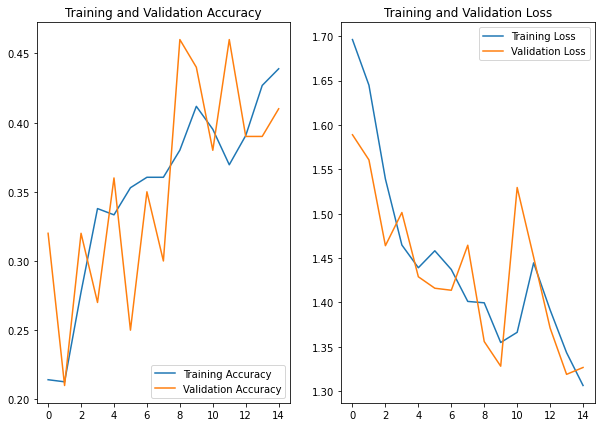

In [22]:
# PLotting Tranning and validation accuracy
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
cnn_rnn_model1.save('model-8.h5')

## We are trying model by increasing last hidden layer neurons in pre-trained model which is ResNet50 with no of batches=64

In [24]:
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(128, activation='relu')(x)  # here we have changed neurons
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False


In [25]:
# CNN-RNN MODEL 1
cnn_rnn_model2 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    GRU(320),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [26]:
# Model Compiling
cnn_rnn_model2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_model2.summary())

batch_size = 64


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 128)           25947136  
_________________________________________________________________
gru_2 (GRU)                  (None, 18, 160)           139200    
_________________________________________________________________
gru_3 (GRU)                  (None, 320)               462720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               41088     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 26,590,789
Trainable params: 3,003,077
Non-trainable params: 23,587,712
__________________________________

In [27]:
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1

In [28]:
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)


In [29]:
# Model fitting
history = cnn_rnn_model2.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Source path =  Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - 123s 12s/step - loss: 1.6734 - categorical_accuracy: 0.2214 - val_loss: 1.6675 - val_categorical_accuracy: 0.2900
Epoch 2/15
11/11 [==============================] - 147s 15s/step - loss: 1.7105 - categorical_accuracy: 0.2086 - val_loss: 1.5740 - val_categorical_accuracy: 0.2300
Epoch 3/15
11/11 [==============================] - 134s 13s/step - loss: 1.5847 - categorical_accuracy: 0.2813 - val_loss: 1.4227 - val_categorical_accuracy: 0.4300
Epoch 4/15
11/11 [==============================] - 145s 14s/step - loss: 1.5102 - categorical_accuracy: 0.2980 - val_loss: 1.3837 - val_categorical_accuracy: 0.4300
Epoch 5/15
11/11 [==============================] - 129s 13s/step - loss: 1.4997 - categorical_accuracy: 0.3650 - val_loss: 1.5064 - val_categorical_accuracy: 0.2700
Epoch 6/15
11/11 [==============================] - 120s 12s/step - loss: 1.4960 - categorical_accuracy: 0.2946 - val_

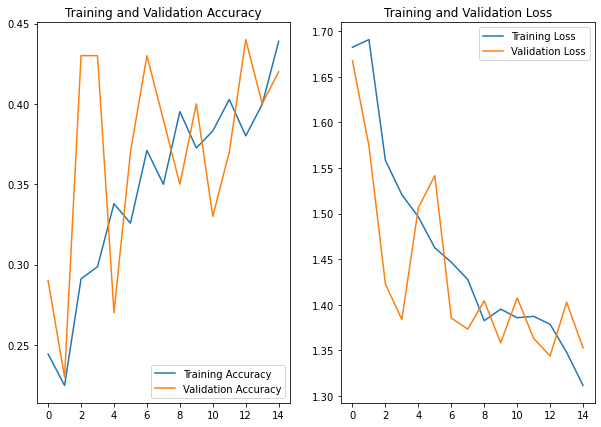

In [30]:
# PLotting Tranning and validation accuracy
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
cnn_rnn_model2.save('model-9.h5')

### Insights of this model
- Here we observed that no changs in the model
- We will try with MobileNet transfer learning


In [32]:
# Lets import import mobilenet

In [33]:
from tensorflow.keras.applications import mobilenet

In [34]:
base_model = mobilenet.MobileNet(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# CNN-RNN MODEL 3
cnn_rnn_m3 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    GRU(320),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# COMPILING THE MODEL
cnn_rnn_m3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_m3.summary())

batch_size = 20
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = cnn_rnn_m3.fit(train_generator,
          epochs=20,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 18, 64)            3491072   
_________________________________________________________________
gru_4 (GRU)                  (None, 18, 160)           108480    
_________________________________________________________________
gru_5 (GRU)                  (None, 320)               462720    
_________________________________________________________________
dropout_2 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               41088     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 645       
Total params: 4,104,005
Trainable params: 875,141
Non-t

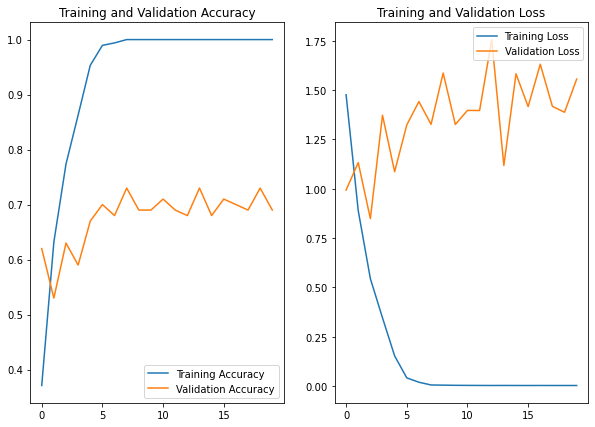

In [35]:
# PLotting Tranning and validation accuracy
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
cnn_rnn_m3.save('model-10.h5')

### Trying the same model with LSTM

In [37]:
base_model = mobilenet.MobileNet(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# CNN-RNN MODEL 3
cnn_rnn_m4 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    LSTM(160, return_sequences=True),
    LSTM(320),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# COMPILING THE MODEL
cnn_rnn_m4.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_m4.summary())

batch_size = 64
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = cnn_rnn_m4.fit(train_generator,
          epochs=12,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 18, 64)            3491072   
_________________________________________________________________
lstm (LSTM)                  (None, 18, 160)           144000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 320)               615680    
_________________________________________________________________
dropout_3 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               41088     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 4,292,485
Trainable params: 1,063,621
Non-trainable params: 3,228,864
____________________________________

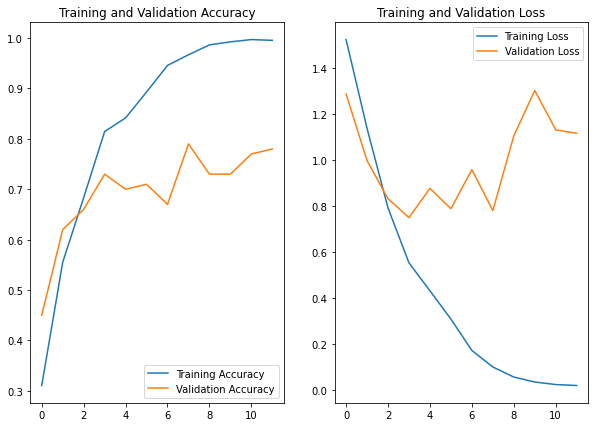

In [38]:
# PLotting Tranning and validation accuracy
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
cnn_rnn_m4.save('model-11.h5')

#### Model is also overfitting so we will try with ResNet50V2 which is advanced version of ResNet50

In [14]:
from tensorflow.keras.applications import ResNet50V2

In [15]:
base_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False



In [16]:
# CNN-RNN MODEL 3
cnn_rnn_model5 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    GRU(320),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])



In [17]:
# COMPILING THE MODEL
cnn_rnn_model5.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_model5.summary())

batch_size = 64


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 64)            24744512  
_________________________________________________________________
gru (GRU)                    (None, 18, 160)           108480    
_________________________________________________________________
gru_1 (GRU)                  (None, 320)               462720    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               41088     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 25,357,445
Trainable params: 1,792,645
Non-trainable params: 23,564,800
____________________________________

In [18]:
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1


In [19]:
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)


In [20]:
# FITTING THE MODEL
history = cnn_rnn_model5.fit(train_generator,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Source path =  Project_data/train ; batch size = 64
Epoch 1/10
11/11 [==============================] - 219s 20s/step - loss: 1.5451 - categorical_accuracy: 0.3265 - val_loss: 1.0716 - val_categorical_accuracy: 0.5300
Epoch 2/10
11/11 [==============================] - 130s 13s/step - loss: 0.8962 - categorical_accuracy: 0.6322 - val_loss: 1.0762 - val_categorical_accuracy: 0.5700
Epoch 3/10
11/11 [==============================] - 103s 10s/step - loss: 0.5470 - categorical_accuracy: 0.7816 - val_loss: 0.9117 - val_categorical_accuracy: 0.6600
Epoch 4/10
11/11 [==============================] - 97s 10s/step - loss: 0.2335 - categorical_accuracy: 0.9073 - val_loss: 1.0222 - val_categorical_accuracy: 0.6600
Epoch 5/10
11/11 [==============================] - 120s 12s/step - loss: 0.1100 - categorical_accuracy: 0.9697 - val_loss: 1.1985 - val_categorical_accuracy: 0.6400

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
11/11 [====================

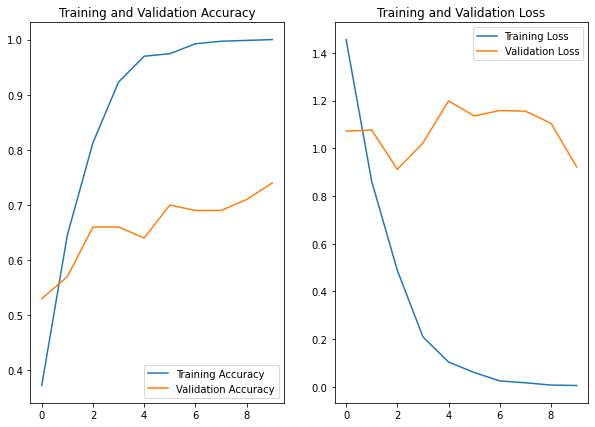

In [23]:
# PLotting Tranning and validation accuracy
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
cnn_rnn_model5.save('model-12.h5')

Model accuracy is not that much good enough

- Trying LSTM instead of GRU

In [25]:
base_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(128, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False


In [26]:

# CNN-RNN MODEL 3
cnn_rnn_model6 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    LSTM(160, return_sequences=True),
    LSTM(320),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),   # Adding this new layer
    Dense(num_classes, activation='softmax')
])


In [27]:
# COMPILING THE MODEL
cnn_rnn_model6.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_model6.summary())

batch_size = 64



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 128)           25924224  
_________________________________________________________________
lstm (LSTM)                  (None, 18, 160)           184960    
_________________________________________________________________
lstm_1 (LSTM)                (None, 320)               615680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               41088     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

In [28]:
# Training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = int(num_train_sequences//batch_size) + 1
    
# Validation set
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = int(num_val_sequences//batch_size) + 1


In [29]:
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)


In [30]:
# FITTING THE MODEL
history = cnn_rnn_model6.fit(train_generator,
          epochs=5,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Source path =  Project_data/train ; batch size = 64
Epoch 1/5
11/11 [==============================] - 133s 13s/step - loss: 1.5351 - categorical_accuracy: 0.2842 - val_loss: 1.1583 - val_categorical_accuracy: 0.4900
Epoch 2/5
11/11 [==============================] - 126s 13s/step - loss: 0.9535 - categorical_accuracy: 0.6170 - val_loss: 0.8689 - val_categorical_accuracy: 0.6600
Epoch 3/5
11/11 [==============================] - 120s 12s/step - loss: 0.6198 - categorical_accuracy: 0.7459 - val_loss: 0.8716 - val_categorical_accuracy: 0.6100
Epoch 4/5
11/11 [==============================] - 94s 9s/step - loss: 0.4458 - categorical_accuracy: 0.8465 - val_loss: 0.9959 - val_categorical_accuracy: 0.7000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/5
11/11 [==============================] - 139s 14s/step - loss: 0.2656 - categorical_accuracy: 0.9240 - val_loss: 1.1915 - val_categorical_accuracy: 0.6400


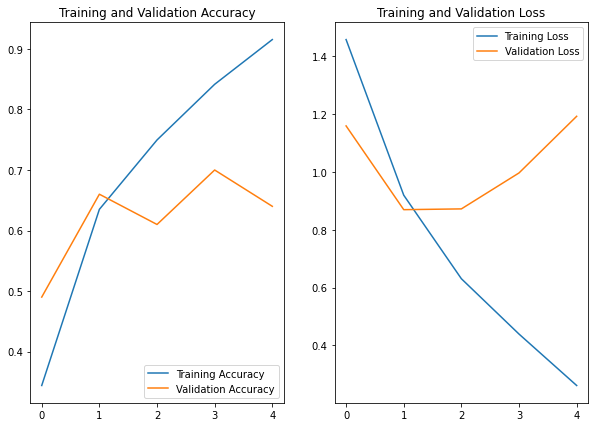

In [32]:
# PLotting Tranning and validation accuracy
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
cnn_rnn_model6.save('model-13.h5')

Model accuracy is not that much good enough